# SPEED workflow: Training on the spatial epigenomic data based on prior information from single-cell data, without image data

Dataset: The E13 mouse embryo spatial ATAC-RNA-seq dataset by Zhang et al ([here](https://doi.org/10.5281/zenodo.14948507))

In [1]:
import torch

print("Whether GPU is detected:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

Whether GPU is detected: True
CUDA version: 11.7


In [2]:
import os
import sys
adata_input_path = 'spATAC/ME13_Raw.h5ad'
pretrain_input_path = 'pretrained/Mouse_embryo.h5ad'
adata_output_path = './ME13_out'

In [3]:
import SPEED
import scanpy as sc

## load the data

Load the spatial epigenomic data and the corresponding single-cell data. 

Make sure their peak sets **have an overlap**, and make sure that the single-cell data has already been trained in stage 1. The trained single-cell peak embeddings should be stored in `adata_sc.varm[peak_name]`

In [4]:
adata = sc.read(adata_input_path)
adata_peak = sc.read(pretrain_input_path)

Process spatial and single-cell epigenomics data by selecting common features.

In [5]:
adata,adata_sc = SPEED.process(adata,adata_peak)

## Initialize the SPEED model

Initialize the model with spatial data and pre-trained single-cell data. 

`is_spatial` is set to `True` during the second stage of training on spatial data. (`is_spatial = False` indicates stage 1 training, while `is_spatial = True` indicates stage 2 training)

`k_degree` is the degree of spatial neighbor used for spatial relative position encoding. For data with a 50 μm resolution, k is defaulted to 5. For data with a 20 μm resolution, k is recommanded to 12.

If there is no paired H&E staining image, set `image` to None.

In [6]:
speed = SPEED.SPEED(adata,image=None,k_degree=5, is_spatial=True, adata_sc=adata_sc)

matrix ready...
use 0-1 matrix...
cell_features ready...
peak features ready...


### Spliting training and validation sets.

`num_workers` is the number of subprocesses for data loading (default = 4).

`data_type` sets the input data format used by SPEED. SPEED will handle this format internally, so no external action is required from the user. For lower GPU memory and faster training, it is recommended to set `dense = False` (default) when training on GPU, and `dense = True` when training on CPU.

`batch_size_cell` and `batch_size_peak` are the batch sizes at the cell-level and peak-level. SPEED will choose automatically according to dataset size, but if the batch size is too large for your GPU, you can reduce it manually.

`split_ratio` sets the proportion of the validation set at both the cell level and peak level. (default = [1/6, 1/6])

In [7]:
speed.setup_data(num_workers=4)

batch_size_cell = 256, batch_size_peak = 16384
split ready...
labels ready...
peak embedding is given
dataset ready...


### Build the neural network model for SPEED.

`emb_features` is the number of embedding features (default = 32).

`dropout_p` is the dropout probability of the model. For spatial data training, `dropout_p` is recommended to 0.4.

In [8]:
speed.build_model(emb_features=32)

## Train the SPEED model

`lr` is the learning rate. `device` specifies whether to train with GPU or CPU.

`epoch_num` is the maximum number of training epochs (default = 500). If no improvement is observed on the validation set within `epo_max` epochs, training is considered converged and will stop (default `epo_max=30`).

`alpha` represents the weight of the constraint on the similarity between peak embeddings of spatial data. The default value is 10. A larger `alpha` means the model relies more on single-cell prior information. 

`beta` represents the importance of image information for spot embedding. The default value is 1. A larger `beta` means the model relies more on image information.

In [ ]:
speed.train(lr=1e-5, device='cuda')

In [10]:
import torch
torch.save(speed.model.state_dict(), f'ME13_out/model.pth')

## Get the results

Use `SPEED.SPEED.get_embedding` to get the low-dimensional embedding.

The spot/cell embeddings will be stored in `adata.obsm['X_SPEED']`. The peak embeddings will be stored in `adata.varm['peak_SPEED']`

In [ ]:
adata = speed.get_embedding(adata)

In [12]:
adata.X = speed.get_denoise_result()

Use `SPEED.SPEED.get_denoise_result` to get the denoised matrix.

In [13]:
plot = ['chr9:13963340-13963840','chr3:57919301-57919801','chr11:26981200-26981700']

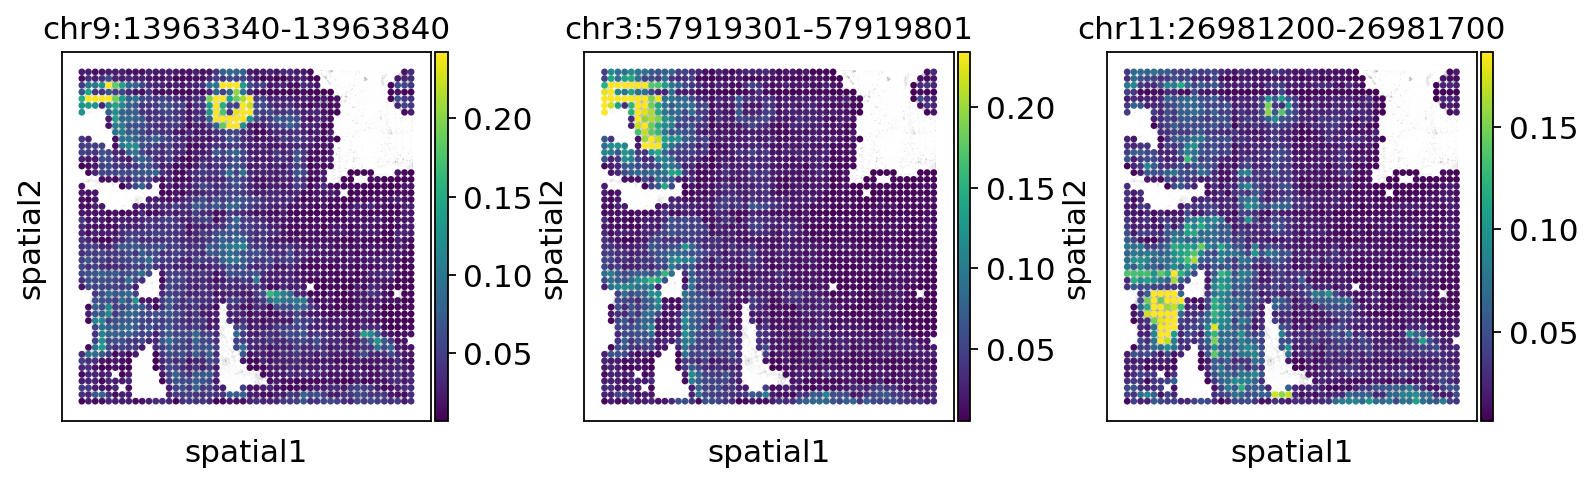

In [14]:
sc.set_figure_params(figsize=(3,3))
sc.pl.spatial(adata,color=plot,basis='spatial',ncols=4,vmax='p99',vmin='p1')

In [15]:
sc.pp.neighbors(adata, use_rep='X_SPEED', random_state=1)
sc.tl.umap(adata)
sc.tl.leiden(adata, random_state=1, key_added="leiden_spot",resolution=1)

/home/wangshuyan/miniconda3/envs/SPEED/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


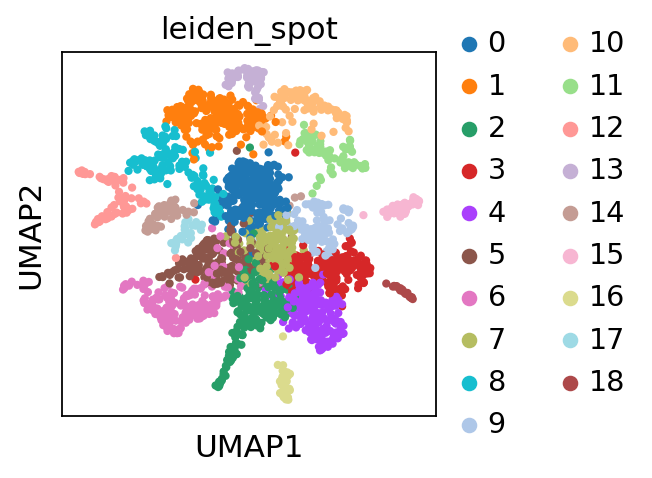

In [16]:
sc.pl.umap(adata,color='leiden_spot')

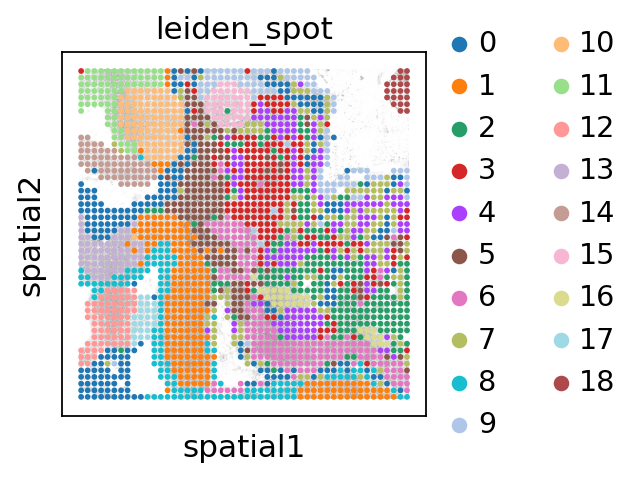

In [17]:
sc.pl.spatial(adata,color='leiden_spot',s=15)

In [15]:
adata.write(f'ME13_out/adata_speed.h5ad')